In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from itertools import combinations
from collections import Counter

In [3]:
data_path = '/workspaces/CaseStudy_PublicisSapient_NER/data/ner_dataset.csv'

In [ ]:
raw_data = pd.read_csv(data_path,encoding='ISO-8859-1')

In [5]:
raw_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
# Fill the sentence number for all the words of the sentence
raw_data['Sentence #'] = raw_data['Sentence #'].ffill()

In [7]:
raw_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
raw_data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

# Sentences & number of words

In [9]:
# Total Number of Sentences

num_words_each_sentence = raw_data['Sentence #'].value_counts()
len(num_words_each_sentence)

47959

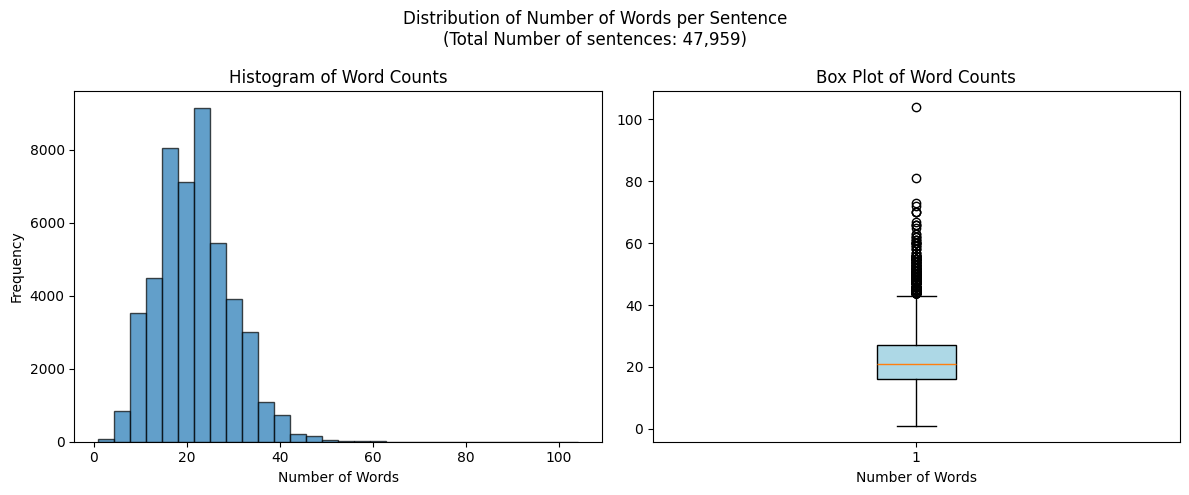

In [10]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram on the left
axs[0].hist(num_words_each_sentence, bins=30, edgecolor='black', alpha=0.7)
axs[0].set_title('Histogram of Word Counts')
axs[0].set_xlabel('Number of Words')
axs[0].set_ylabel('Frequency')

# Box plot on the right
axs[1].boxplot(num_words_each_sentence, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].set_title('Box Plot of Word Counts')
axs[1].set_xlabel('Number of Words')
fig.suptitle('Distribution of Number of Words per Sentence\n(Total Number of sentences: 47,959)')
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Word Occurances

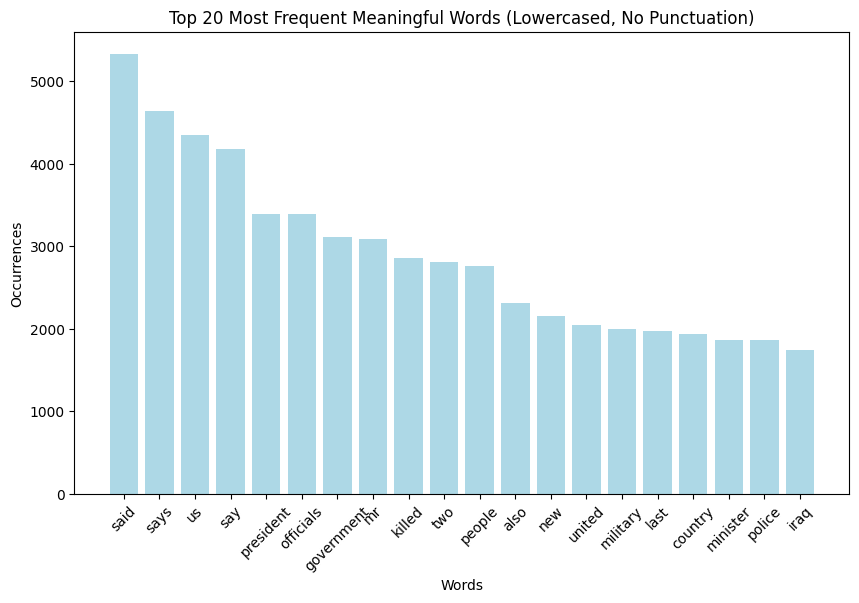

In [36]:
# Remove non-string values and convert to empty strings if necessary
raw_data['Word'] = raw_data['Word'].astype(str).str.lower()

# Remove special characters and punctuation
raw_data['Word'] = raw_data['Word'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x) if isinstance(x, str) else '')

# Drop any empty strings that might result from this cleaning
raw_data = raw_data[raw_data['Word'] != '']

# Recalculate word counts after cleaning
word_counts = raw_data['Word'].value_counts()

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Filter out stop words from the word count
filtered_words = word_counts[~word_counts.index.isin(stop_words)]

# Top N most frequent meaningful words
top_n = 20
top_meaningful_words = filtered_words.head(top_n)

# Plotting the top N most frequent meaningful words
plt.figure(figsize=(10, 6))
plt.bar(top_meaningful_words.index, top_meaningful_words.values, color='lightblue')
plt.title(f'Top {top_n} Most Frequent Meaningful Words (Lowercased, No Punctuation)')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()


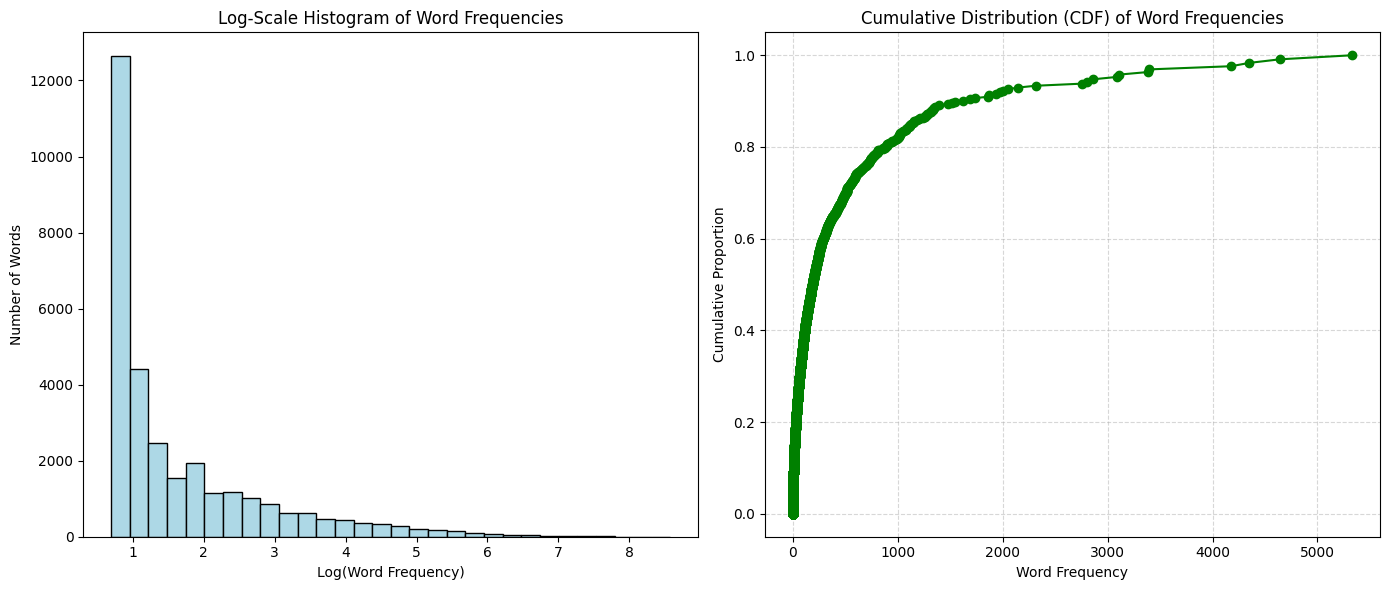

In [38]:

# Log-Scale Histogram
plt.figure(figsize=(14, 6))

# Log-Scale Histogram
plt.subplot(1, 2, 1)
plt.hist(np.log1p(filtered_words), bins=30, edgecolor='black', color='lightblue')
plt.title('Log-Scale Histogram of Word Frequencies')
plt.xlabel('Log(Word Frequency)')
plt.ylabel('Number of Words')

# Cumulative Distribution Plot (CDF)
sorted_counts = np.sort(filtered_words)
cumulative = np.cumsum(sorted_counts) / np.sum(sorted_counts)

plt.subplot(1, 2, 2)
plt.plot(sorted_counts, cumulative, marker='o', linestyle='-', color='green')
plt.title('Cumulative Distribution (CDF) of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Cumulative Proportion')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Tag Analysis

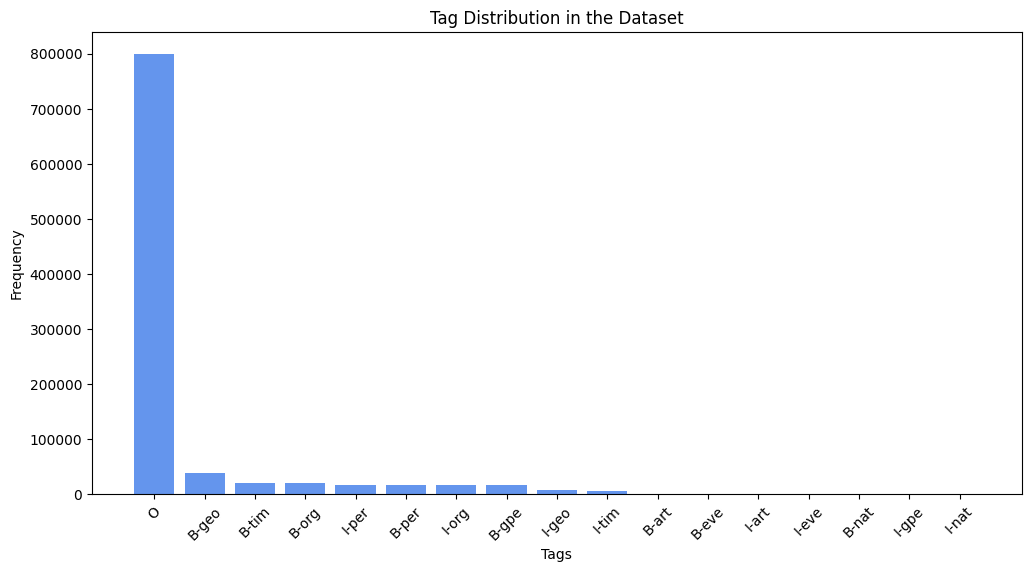

In [43]:
# Calculate the tag frequency distribution
tag_counts = raw_data['Tag'].value_counts()

# Plotting the tag distribution
plt.figure(figsize=(12, 6))
plt.bar(tag_counts.index, tag_counts.values, color='cornflowerblue')
plt.title('Tag Distribution in the Dataset')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [44]:
tag_counts.index

Index(['O', 'B-geo', 'B-tim', 'B-org', 'I-per', 'B-per', 'I-org', 'B-gpe',
       'I-geo', 'I-tim', 'B-art', 'B-eve', 'I-art', 'I-eve', 'B-nat', 'I-gpe',
       'I-nat'],
      dtype='object', name='Tag')

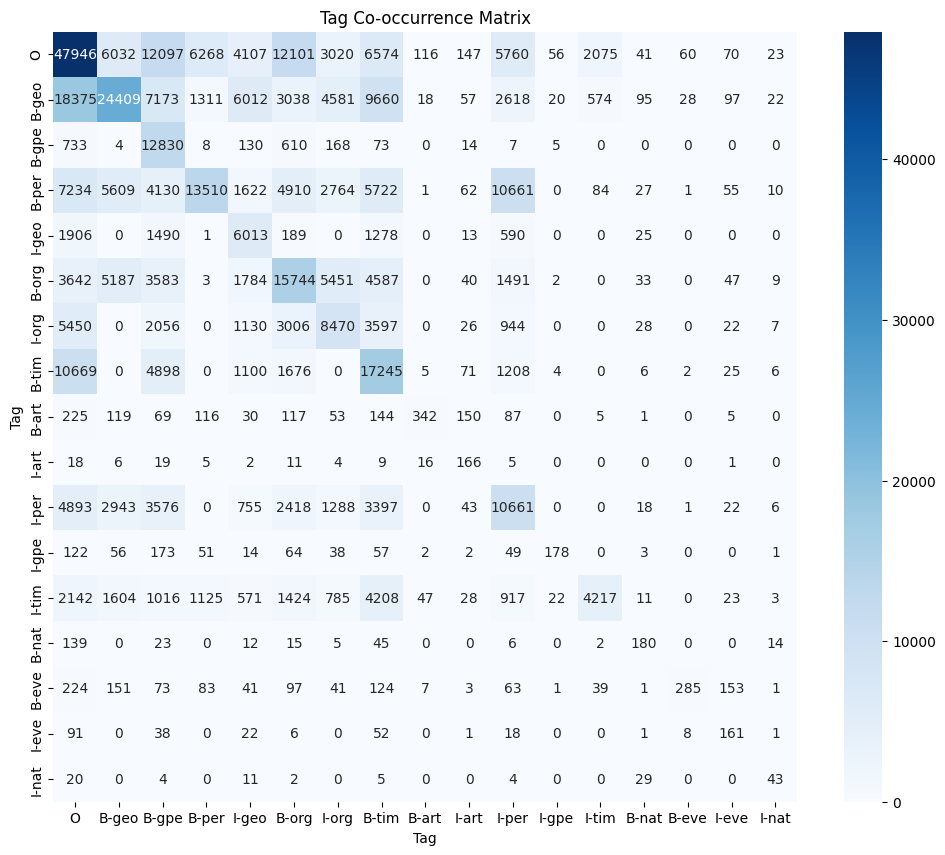

In [47]:
# Group tags by sentence
tag_sequences = raw_data.groupby('Sentence #')['Tag'].apply(list)

# Flattened list of all tag pairs
tag_pairs = []

# Efficiently generate tag pairs
for tags in tag_sequences:
    unique_tags = set(tags)
    tag_pairs.extend(combinations(unique_tags, 2))
    tag_pairs.extend((tag, tag) for tag in unique_tags)  # Diagonal (same tag)

# Count occurrences using Counter
pair_counts = Counter(tag_pairs)

# Create the co-occurrence matrix
unique_tags = raw_data['Tag'].unique()
co_occurrence_matrix = pd.DataFrame(0, index=unique_tags, columns=unique_tags)

# Fill the matrix using the Counter
for (tag1, tag2), count in pair_counts.items():
    co_occurrence_matrix.loc[tag1, tag2] = count

# Plot the optimized heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Tag Co-occurrence Matrix')
plt.xlabel('Tag')
plt.ylabel('Tag')
plt.show()


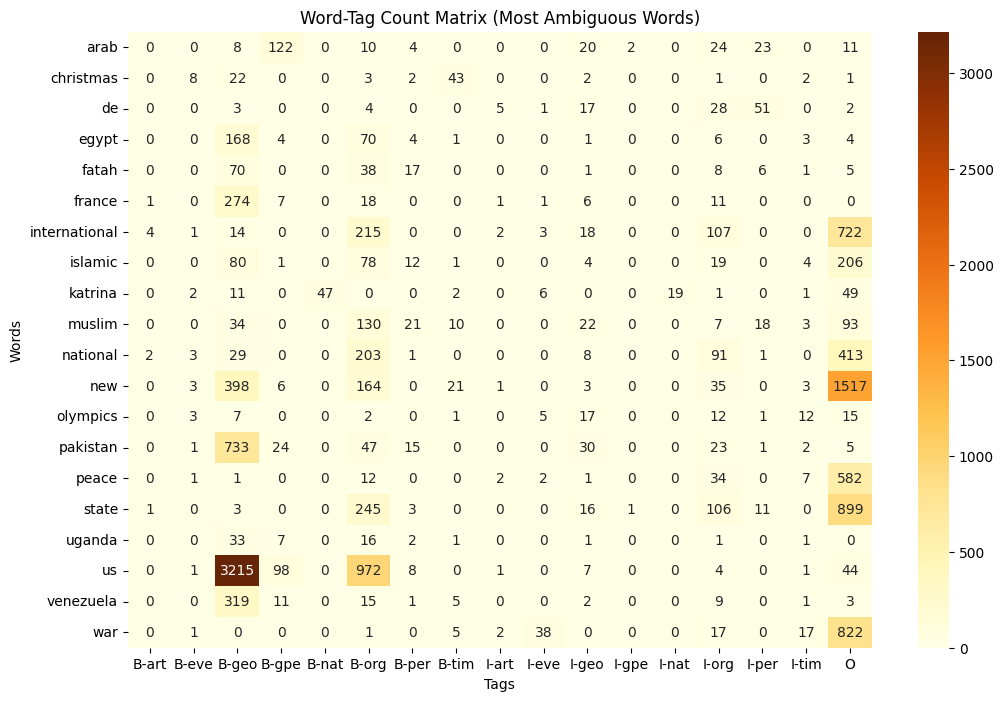

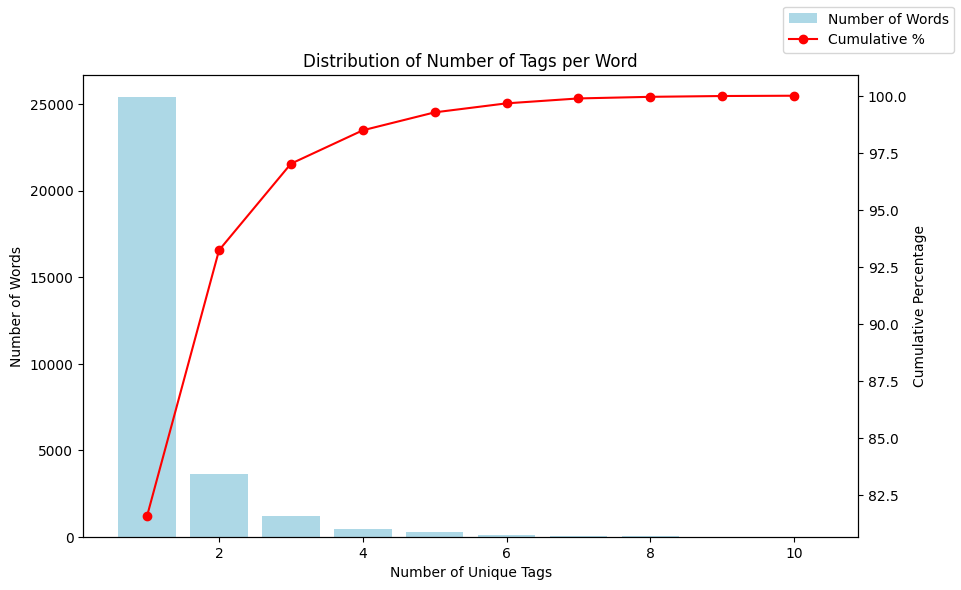

Example of Ambiguous Word 'uganda': ['B-gpe', 'B-geo', 'I-geo', 'B-org', 'I-tim', 'B-per', 'I-org', 'B-tim']


In [68]:
# Create a copy of the raw data to keep original intact
cleaned_data = raw_data.copy()

# Preprocessing: Lowercase, remove special characters, remove stopwords
cleaned_data['Word'] = cleaned_data['Word'].astype(str).str.lower()
cleaned_data['Word'] = cleaned_data['Word'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x))

# Remove empty strings and stop words
stop_words = set(stopwords.words('english'))
cleaned_data = cleaned_data[cleaned_data['Word'] != '']
cleaned_data = cleaned_data[~cleaned_data['Word'].isin(stop_words)]

# Step 1: Calculate the number of unique tags per word
word_tag_counts = cleaned_data.groupby('Word')['Tag'].nunique().sort_values(ascending=False)

# Step 2: Create a word-tag count matrix for the most ambiguous words (top 20)
top_ambiguous_words = word_tag_counts.nlargest(20).index
filtered_data = cleaned_data[cleaned_data['Word'].isin(top_ambiguous_words)]
word_tag_matrix = filtered_data.groupby(['Word', 'Tag']).size().unstack(fill_value=0)

# Step 3: Plot the word-tag count matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(word_tag_matrix, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Word-Tag Count Matrix (Most Ambiguous Words)')
plt.xlabel('Tags')
plt.ylabel('Words')
plt.show()

# Step 4: Distribution of number of tags per word
tag_count_distribution = word_tag_counts.value_counts().sort_index()
cumulative_percentage = tag_count_distribution.cumsum() / tag_count_distribution.sum() * 100

# Step 5: Plotting the cumulative distribution
fig, ax1 = plt.subplots(figsize=(10, 6))

# Histogram of tag counts per word
ax1.bar(tag_count_distribution.index, tag_count_distribution.values, color='lightblue', label='Number of Words')
ax1.set_xlabel('Number of Unique Tags')
ax1.set_ylabel('Number of Words')
ax1.set_title('Distribution of Number of Tags per Word')

# Cumulative distribution plot (second y-axis)
ax2 = ax1.twinx()
ax2.plot(tag_count_distribution.index, cumulative_percentage, color='red', marker='o', label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage')
ax2.grid(False)

# Adding legend
fig.legend(loc="upper right")
plt.show()

# Step 6: Example Ambiguous Word - Display "uganda"
example_word = "uganda"
example_tags = cleaned_data[cleaned_data['Word'] == example_word]['Tag'].unique()
print(f"Example of Ambiguous Word '{example_word}': {list(example_tags)}")
